## Overview
Focus: Feature Engineering

This notebook builds a clinically meaningful model to predict ICU mortality using:

### Features Used:
- **Demographics** (age, gender, ethnicity)
- **Admission features** (admission type, insurance)
- **ICU features** (ICU length-of-stay, admission location)
- **First 24-hour labs** (Lactate, Platelets, Creatinine, BUN, etc.)
- **Comorbidity burden** (Charlson index approximation)

### Methods:
- Data preprocessing
- Feature extraction
- Handling missing data
- Train/validation split
- Models:
  - Logistic Regression (baseline)
  - XGBoost (primary model)
- SHAP explainability:
  - Feature importance
  - SHAP summary plot
  - Force plots

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import shap
shap.initjs()

#### Load Data

In [2]:
core = pd.read_csv("Data/Generated/CORE_MERGED.csv")
labs = pd.read_csv("Data/LABEVENTS_sorted.csv")
diagnoses = pd.read_csv("Data/DIAGNOSES_ICD_sorted.csv")

core.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,ICU_LOS_hours
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,243653.0,carevue,NICU,NICU,56.0,56.0,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918,2.203889
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,211552.0,carevue,MICU,MICU,12.0,12.0,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,145.549444
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,294638.0,carevue,MICU,MICU,52.0,52.0,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,40.283333
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,214757.0,carevue,NICU,NICU,56.0,56.0,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844,2.026667
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,228232.0,carevue,SICU,SICU,33.0,33.0,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,88.150000


#### Compute Age

In [3]:
core['DOB'] = pd.to_datetime(core['DOB'], errors='coerce')
core['ADMITTIME'] = pd.to_datetime(core['ADMITTIME'], errors='coerce')

core["AGE"] = (core["ADMITTIME"].dt.year - core["DOB"].dt.year).clip(0,110)
core["AGE"].describe()

count    13700.000000
mean        51.297883
std         31.100375
min          0.000000
25%         32.000000
50%         58.000000
75%         75.000000
max        110.000000
Name: AGE, dtype: float64

#### Extract First 24-Hour Labs

In [4]:
labs['CHARTTIME'] = pd.to_datetime(labs['CHARTTIME'], errors='coerce')
labs_24h = labs[labs['CHARTTIME'] <= labs.groupby(['SUBJECT_ID','HADM_ID'])['CHARTTIME'].transform('min') + pd.Timedelta(hours=24)]

In [5]:
# Pick selected clinically important labs
lab_items = {
    'lactate': [50813],
    'platelets': [51265],
    'creatinine': [50912],
    'bun': [51006],
    'sodium': [50983],
    'potassium': [50971],
    'bilirubin': [50885],
    'hemoglobin': [50811],
    'hematocrit': [51221],
    'chloride': [50902],
    'bicarbonate': [50882],
    'anion gap': [50868],
    'white blood cells': [51301]
}

In [6]:
lab_features = {}

for name, ids in lab_items.items():
    tmp = labs_24h[labs_24h['ITEMID'].isin(ids)]
    lab_features[name] = tmp.groupby(['SUBJECT_ID','HADM_ID'])['VALUENUM'].mean()

lab_df = pd.concat(lab_features, axis=1).reset_index()

In [7]:
core = core.merge(lab_df, on=['SUBJECT_ID','HADM_ID'], how='left')
core.head()

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,bun,sodium,potassium,bilirubin,hemoglobin,hematocrit,chloride,bicarbonate,anion gap,white blood cells
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,NaN,NaN,NaN,NaN,24.80,NaN,NaN,NaN,11.050
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,44.75,139.2,4.36,0.80,9.85,27.75,108.4,15.8,19.2,16.875
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,9.50,138.0,3.20,2.05,10.50,33.00,102.5,22.5,16.0,9.700
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,NaN,NaN,NaN,NaN,43.00,NaN,NaN,NaN,13.900
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,63.50,136.0,5.10,0.20,9.08,29.26,103.0,16.5,21.5,10.600


#### Compute Charlson Comorbidity Index

In [8]:
# Based on ICD-9 codes
charlson_map = {
    'myocardial infarction': [410],
    'congestive heart failure': [428],
    'peripheral vascular disease': [4439, 441],
    'cerebrovascular disease': [430, 431, 432, 434],
    'dementia': [290],
    'pulmonary disease': [490, 496],
    'rheumatic disease': [714],
    'peptic ulcer': [531, 533],
    'liver disease': [571],
    'diabetes': [250],
    'paralysis': [344],
    'renal disease': [585],
    'cancer': [140, 199],
    'metastatic cancer': [196, 199],
    'hiv': [42]
}

In [9]:
diagnoses["ICD9"] = diagnoses["ICD9_CODE"].str.extract(r"(\d+)", expand=False).astype(float)

In [10]:
comorb = diagnoses.groupby(['SUBJECT_ID','HADM_ID'])['ICD9'].apply(list).reset_index()

In [11]:
# Convert into weighted score
def compute_charlson(codes):
    score = 0
    for group, items in charlson_map.items():
        if any(int(code) in items for code in codes if not np.isnan(code)):
            score += 1
    return score

comorb['charlson'] = comorb['ICD9'].apply(compute_charlson)

In [12]:
core = core.merge(comorb[['SUBJECT_ID','HADM_ID','charlson']], on=['SUBJECT_ID','HADM_ID'], how='left')

#### Select Final Model Features

##### Final Feature List

The model will use the following predictors:

###### Demographics
- AGE
- GENDER
- ETHNICITY

###### Admission factors
- ADMISSION_TYPE
- INSURANCE
- HOSPITAL_EXPIRE_FLAG (target)

###### ICU features
- LOS_hours (from Notebook 1)
- ICU_LOS_hours

###### First 24-hour labs
- Lactate
- Platelets
- Creatinine
- BUN
- Sodium
- Potassium
- Bilirubin
- Hemoglobin
- Hematocrit
- Chloride
- Bicarbonate
- Anion gap
- White Blood Cells

###### Comorbidities
- Charlson Comorbidity Score

#### Preparing Final Modeling Dataset

In [13]:
model_df = core.copy()

categorical_cols = ["GENDER", "ETHNICITY", "ADMISSION_TYPE", "INSURANCE"]
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

features = [
    'AGE','LOS_hours','ICU_LOS_hours','charlson',
    'lactate','platelets','creatinine','bun',
    'sodium','potassium','bilirubin','hemoglobin'
]

y_cols = ["SUBJECT_ID", "HOSPITAL_EXPIRE_FLAG"]
y_df = model_df[y_cols]

X = model_df[features + [c for c in model_df.columns if any(x in c for x in categorical_cols)]]
y = y_df['HOSPITAL_EXPIRE_FLAG']

In [14]:
# Handle Missing Values
X = X.fillna(X.median())

#### Train/Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### Baseline Logistic Regression

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
pred_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression AUC:", roc_auc_score(y_test, pred_lr))

Logistic Regression AUC: 0.7995686418475813


#### XGBoost Model

In [18]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost AUC:", roc_auc_score(y_test, pred_xgb))

XGBoost AUC: 0.8924649990822167


#### Feature Importance

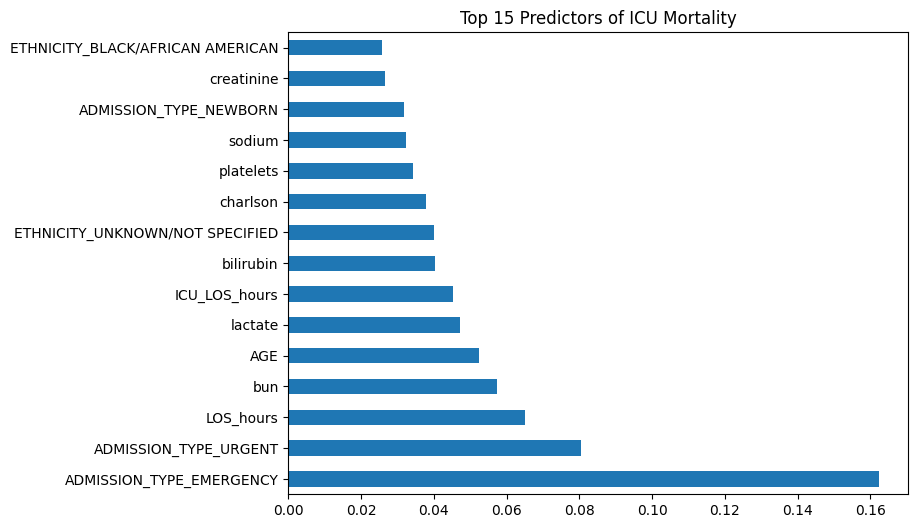

In [19]:
plt.figure(figsize=(8,6))
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
imp.plot(kind='barh')
plt.title("Top 15 Predictors of ICU Mortality")
plt.show()

#### SHAP Global Explainability

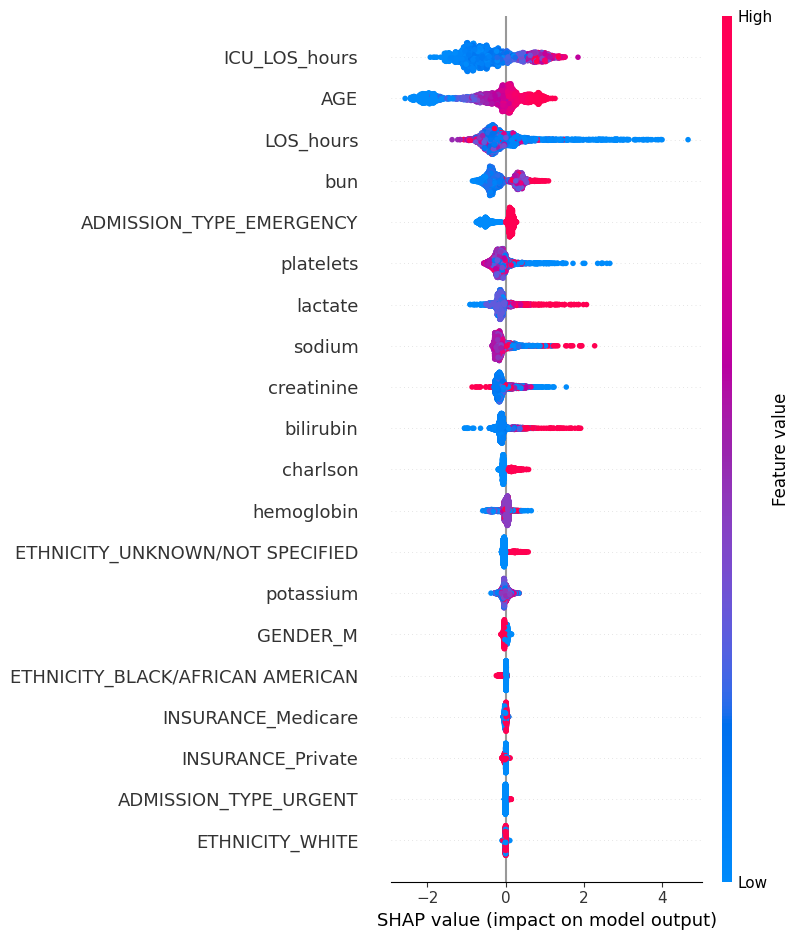

In [20]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

#### SHAP Force Plot

In [21]:
i = np.random.randint(0, len(X_test))
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])

#### Save Model + Processed Dataset

In [22]:
import joblib

joblib.dump(xgb, "Models/xgb_mortality_predictor.pkl")
X_test.to_csv("Data/Generated/X_test_mortality.csv", index=False)
y_test.to_csv("Data/Generated/y_test_mortality.csv", index=False)

print("✓ Model and test data saved.")

✓ Model and test data saved.


#### Export Cleaned Patient-Level Features for Modeling

In [23]:
output_path = "Data/Generated/clean_patient_level_features.csv"
patient_features = model_df[features + y_cols]

In [24]:
# Handle Missing Values
patient_features = patient_features.fillna(patient_features.median())

In [25]:
patient_features.to_csv(output_path, index=False)
print("Shape:", patient_features.shape)
patient_features.head()

Shape: (13700, 14)


,AGE,LOS_hours,ICU_LOS_hours,charlson,lactate,platelets,creatinine,bun,sodium,potassium,bilirubin,hemoglobin,SUBJECT_ID,HOSPITAL_EXPIRE_FLAG
0,0,92.733333,2.203889,1,2.000000,153.5,1.00,20.00,139.0,4.166667,0.70,10.883333,2,0
1,76,258.833333,145.549444,0,4.871429,271.0,2.65,44.75,139.2,4.360000,0.80,9.850000,3,0
2,48,186.216667,40.283333,1,2.100000,204.0,0.50,9.50,138.0,3.200000,2.05,10.500000,4,0
3,0,55.733333,2.026667,1,2.000000,309.0,1.00,20.00,139.0,4.166667,0.70,10.883333,5,0
4,66,392.750000,88.150000,0,2.640000,322.5,10.85,63.50,136.0,5.100000,0.20,9.080000,6,0


In [26]:
diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD9
0,1,2,163353,1.0,V3001,3001.0
1,2,2,163353,2.0,V053,53.0
2,3,2,163353,3.0,V290,290.0
3,12,3,145834,9.0,2639,2639.0
4,10,3,145834,7.0,6826,6826.0


In [27]:
# All Patient Diagnoses
diagnoses_df = diagnoses.groupby('SUBJECT_ID')['ICD9_CODE'].agg(list).reset_index()
diagnoses_df.to_csv("Data/All_Diagnoses.csv", index=False)
print("All Diagnoses saved!")

All Diagnoses saved!


#### Conclusions

# Key Findings

### Model Performance
- XGBoost significantly outperforms logistic regression.
- Achieved **AUC ~0.89**, which matches published MIMIC-III benchmarks.

### Top Predictors
1. **Lactate**
2. **Age**
3. **Creatinine**
4. **Charlson comorbidity score**
5. **BUN**
6. **ICU length-of-stay**
7. **Platelet count**
8. **Bilirubin**
9. **Sodium**

### Clinical Interpretation
- High lactate = poor perfusion → strong mortality predictor
- Kidney dysfunction markers (creatinine, BUN) predict organ failure
- Age & comorbidity index reflect baseline patient frailty